In [38]:
#Mounting drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ML_Assignment2_Dataset
!pip install torcheval
!pip install torchmetrics
!pip install torchinfo
!pip install torchviz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ML_Assignment2_Dataset
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=6ea5d0151bafe6d764f9e84fa9aa2c22127cb6ad3c8c5ed0eab29dc4460a91dc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [39]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from torch.nn.functional import normalize
from sklearn.model_selection import train_test_split
from torcheval.metrics import BinaryAccuracy
from torch.nn import functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import BinaryConfusionMatrix, BinaryROC
from sklearn.metrics import precision_recall_fscore_support
import time
from torchinfo import summary
from torchviz import make_dot

In [3]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


# **Step 1. Loading the Dataset and main statistics**

### a. Load the dataset

In [34]:
df_input = pd.read_csv('./dataset.csv')

### b. Analyze the dataset

In [30]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


In [36]:
df_input.describe()

,f1,f2,f3,f4,f5,f6,f7,target
count,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000,766.000000
mean,3.849869,120.909922,69.118799,20.543081,80.092689,31.998172,0.472817,0.349869
std,3.371494,31.927057,19.376901,15.950089,115.298955,7.893111,0.331876,0.477240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,62.500000,0.000000,0.000000,27.300000,0.244000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.374500,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.750000,36.600000,0.626750,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


### c. Convert columns to numeric type and handle invalid alphabets by replacing with mean value

In [35]:
#Convert each column to numeric type, if there are non numeric values then replace with None. Then replace these None values with mean.
for col in df_input.columns:
  df_input[col] = pd.to_numeric(df_input[col], errors='coerce')
  mean_value = np.ceil(df_input[col].mean())
  df_input[col] = df_input[col].fillna(mean_value)

### d. Plots

##### i. Feature Histogram

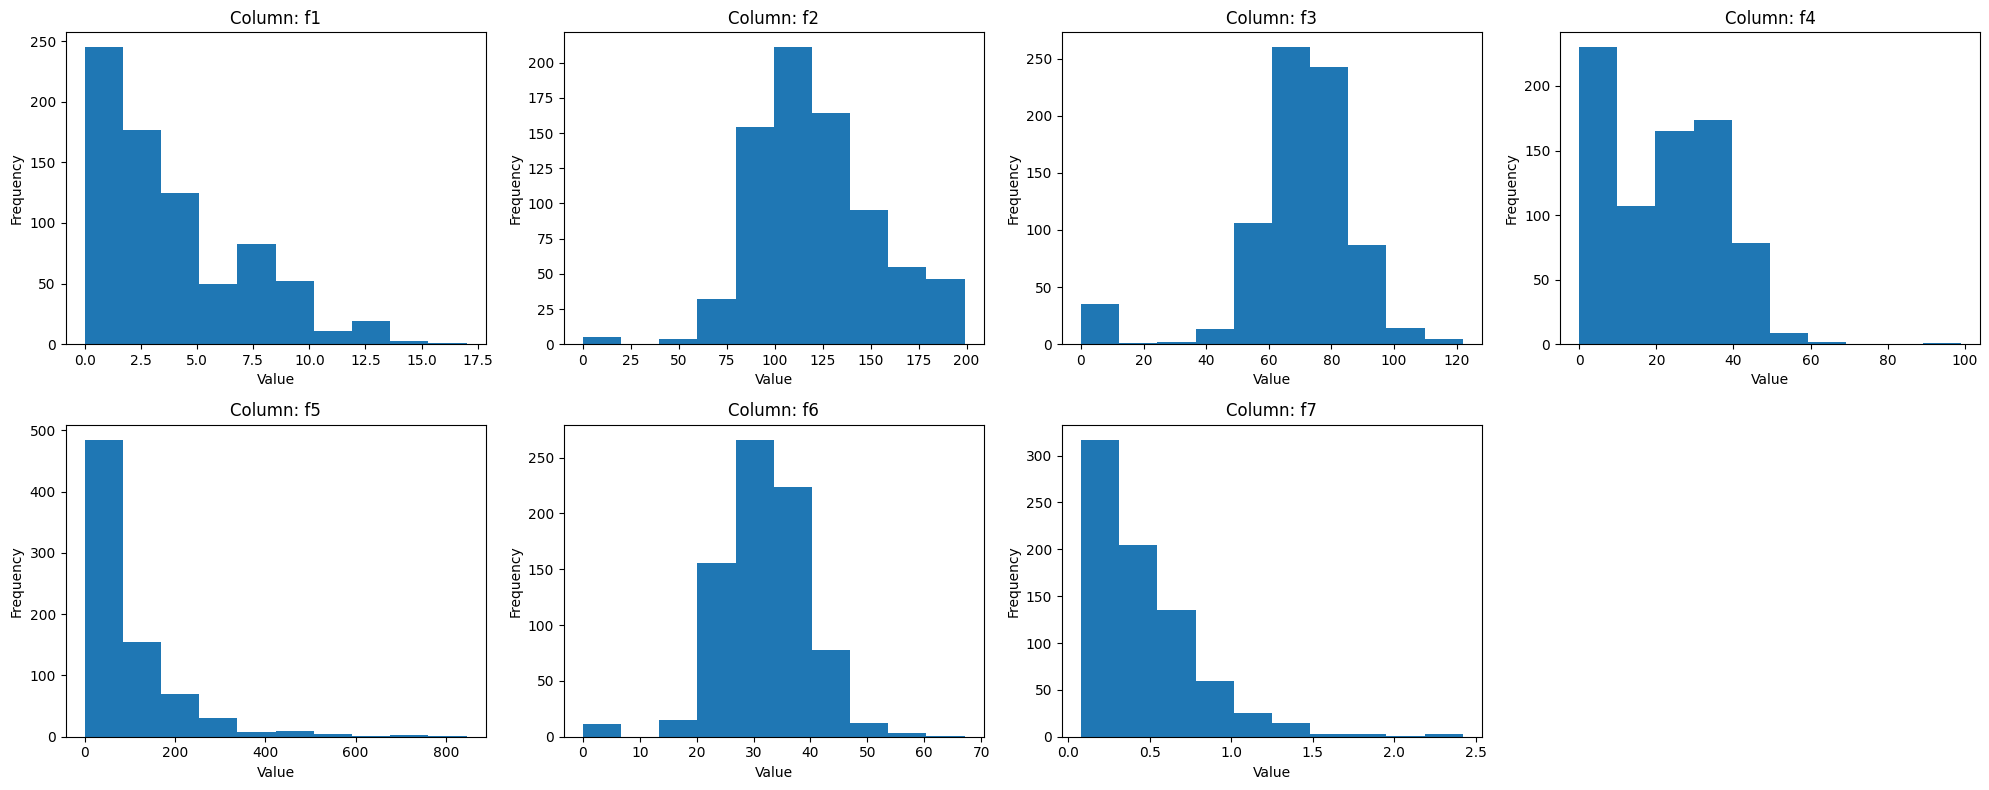

In [37]:
column_list = list(df_input.columns)
column_list.remove('target')
plt.figure(figsize=(20, 8))
for index, column in zip(range(1,8), column_list):
  plt.subplot(2,4,index)
  plt.hist(df_input[column])
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title(f'Column: {column}')
  plt.tight_layout()
  plt.plot()


##### ii. Target histogram

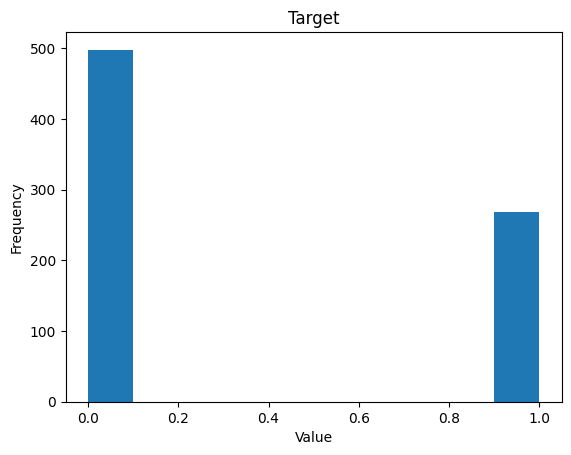

In [8]:
plt.hist(df_input['target'])
plt.title('Target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

##### iii. Correlation Matrix

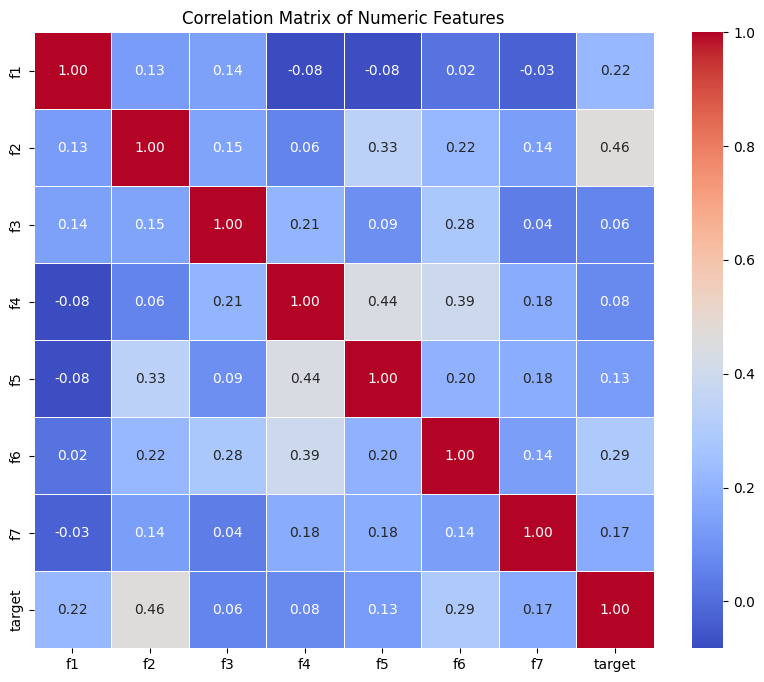

In [9]:
#Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_input[df_input.columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# **Step 2. Preprocessing and Splitting the Dataset**

### a. Preprocessing

##### i. Data Augmentation

In [10]:
df_minority = df_input[df_input['target'] == 1]
df_majority = df_input[df_input['target'] == 0]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

df_input = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

##### ii. Convert to tensors for normalization

In [11]:
X = torch.tensor(df_input.drop(['target'], axis=1).values, dtype=torch.float)
y = torch.tensor(df_input['target'].values, dtype=torch.float)

##### iii. Normalization

In [12]:
X_normalized = normalize(X, p=2, dim=0)

### b. Train Test Split

In [13]:
#Split 80:10:10

#80:20 split for training and remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

#Split the remaining data 50:50 for equal validation and testing set
X_validation, X_test, y_validation, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

print(f'X_train: {X_train.shape} | X_validation: {X_validation.shape} | X_test: {X_test.shape}')
print(f'\ny_train: {y_train.shape} | y_validation: {y_validation.shape} | y_test: {y_test.shape}')

X_train: torch.Size([796, 7]) | X_validation: torch.Size([100, 7]) | X_test: torch.Size([100, 7])

y_train: torch.Size([796]) | y_validation: torch.Size([100]) | y_test: torch.Size([100])


# Step 3. Defining the Neural Network

In [14]:
class NeuralNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features=7, out_features=32)
    self.fc2 = nn.Linear(in_features=32, out_features=8)
    self.fc3 = nn.Linear(in_features=8, out_features=1)
    self.dropout = nn.Dropout(0)
    self.act_func = getattr(F,'relu')

  def forward(self, X):
    X = self.act_func(self.fc1(X))
    X = self.dropout(X)
    X = self.act_func(self.fc2(X))
    X = self.dropout(X)
    X = self.fc3(X)
    return X

In [15]:
torch.manual_seed(42)
model = NeuralNet().to(device)

In [16]:
summary(model, input_size=(128, 7))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [128, 1]                  --
├─Linear: 1-1                            [128, 32]                 256
├─Dropout: 1-2                           [128, 32]                 --
├─Linear: 1-3                            [128, 8]                  264
├─Dropout: 1-4                           [128, 8]                  --
├─Linear: 1-5                            [128, 1]                  9
Total params: 529
Trainable params: 529
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

In [40]:
dot = make_dot(y_test_logit, params=dict(model.named_parameters()))
dot.render("model_visualization", format="png")

'model_visualization.png'

# Step 4. Training the Neural Network

### 1. Define Loss Function

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

##### Accuracy Function

In [18]:
def accuracy_fn(y_pred_value, y_true_value):
  metric = BinaryAccuracy()
  metric.update(y_pred_value.squeeze(), y_true_value)
  return round(metric.compute().item()*100, 2)

### 2. Define Optimizer

In [19]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 2e-3, weight_decay = 1e-5)

### 3. Setup a training loop

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000
batch_size = 256

epoch_count = []
training_accuracy_list = []
validation_accuracy_list = []
training_loss_list = []
validation_loss_list = []

# Moving data to CUDA if available
X_train, y_train = X_train.to(device), y_train.to(device)
X_validation, y_validation = X_validation.to(device), y_validation.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Dataset and Dataloader for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_start_time = time.time()

for epoch in range(epochs):
  epoch_count.append(epoch)

  #Set our model to training mode
  model.train()

  batch_training_loss_list = []
  batch_training_accuracy_list = []

  for X_train_batch, y_train_batch in train_loader:
    #1. Forward Pass
    #Calculate y_logits using forward pass (Since we have used BCEWithLogitsLoss, we need logits)
    y_logits = model.forward(X_train_batch).squeeze()
    #Pass through sigmoid for calculating accuracy
    y_pred = torch.round(torch.sigmoid(y_logits))

    #2. Calculate Loss Function/ Accuracy

    loss = loss_fn(y_logits, y_train_batch)
    batch_training_loss_list.append(loss.detach().cpu().numpy())
    batch_training_accuracy_list.append(accuracy_fn(y_pred_value=y_pred, y_true_value=y_train_batch))

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Backpropagation
    loss.backward()

    #5. Optimizer Step
    optimizer.step()

  training_loss_list.append(np.mean(batch_training_loss_list))
  training_accuracy_list.append(np.mean(batch_training_accuracy_list))

  #VALIDATION LOOP
  model.eval()
  with torch.inference_mode():
    #1. Forward Pass
    validation_logits = model.forward(X_validation).squeeze()
    validation_preds = torch.round(torch.sigmoid(validation_logits))

    #2. Calculate Loss Function/ Accuracy
    validation_loss = loss_fn(validation_logits, y_validation)
    validation_loss_list.append(validation_loss.detach().cpu().numpy())
    validation_accuracy = accuracy_fn(y_pred_value=validation_preds, y_true_value=y_validation)
    validation_accuracy_list.append(validation_accuracy)

  if epoch % 200 == 0:
    print(f'Epoch: {epoch} | Training Loss: {training_loss_list[epoch]:.5f} | Training Accuracy: {round(training_accuracy_list[epoch], 2)} | Validation Loss: {validation_loss:.5f} | Validation Accuracy: {validation_accuracy}')

train_end_time = time.time()
print(f'\nModel Hyperparameters - Epochs: {epochs} ; Batch Size: {batch_size}')
print(f'Time taken by the model for training: {train_end_time - train_start_time}')

Epoch: 0 | Training Loss: 0.69738 | Training Accuracy: 48.22 | Validation Loss: 0.69595 | Validation Accuracy: 49.0
Epoch: 200 | Training Loss: 0.52480 | Training Accuracy: 74.45 | Validation Loss: 0.57424 | Validation Accuracy: 69.0
Epoch: 400 | Training Loss: 0.48232 | Training Accuracy: 78.28 | Validation Loss: 0.53078 | Validation Accuracy: 75.0
Epoch: 600 | Training Loss: 0.49443 | Training Accuracy: 74.72 | Validation Loss: 0.51783 | Validation Accuracy: 77.0
Epoch: 800 | Training Loss: 0.50338 | Training Accuracy: 75.0 | Validation Loss: 0.51728 | Validation Accuracy: 76.0
Epoch: 1000 | Training Loss: 0.48334 | Training Accuracy: 75.68 | Validation Loss: 0.51570 | Validation Accuracy: 77.0
Epoch: 1200 | Training Loss: 0.52286 | Training Accuracy: 74.89 | Validation Loss: 0.51428 | Validation Accuracy: 76.0
Epoch: 1400 | Training Loss: 0.51413 | Training Accuracy: 74.5 | Validation Loss: 0.51285 | Validation Accuracy: 77.0
Epoch: 1600 | Training Loss: 0.50450 | Training Accuracy:

### Test Data

In [21]:
y_test_logit = model.forward(X_test)
y_test_pred = torch.round(torch.sigmoid(y_test_logit))

test_loss = loss_fn(y_test_logit.squeeze(), y_test).detach().cpu().numpy()

test_accuracy = accuracy_fn(y_pred_value=y_test_pred, y_true_value=y_test)
print(f'Test Accuracy: {test_accuracy}')

precision, recall, f1, _ = precision_recall_fscore_support(y_test.cpu(), y_test_pred.squeeze().detach().cpu(), average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 79.0
Precision: 0.7667
Recall: 0.8679
F1 Score: 0.8142


#### Save model parameters

In [22]:
torch.save(model.state_dict(), 'ModelParams/state_dict_new.pth')
torch.save(model, 'ModelParams/complete_model_new.pth')

### 7. Visualize the results

##### a. Training, Validation and Testing Accuracy

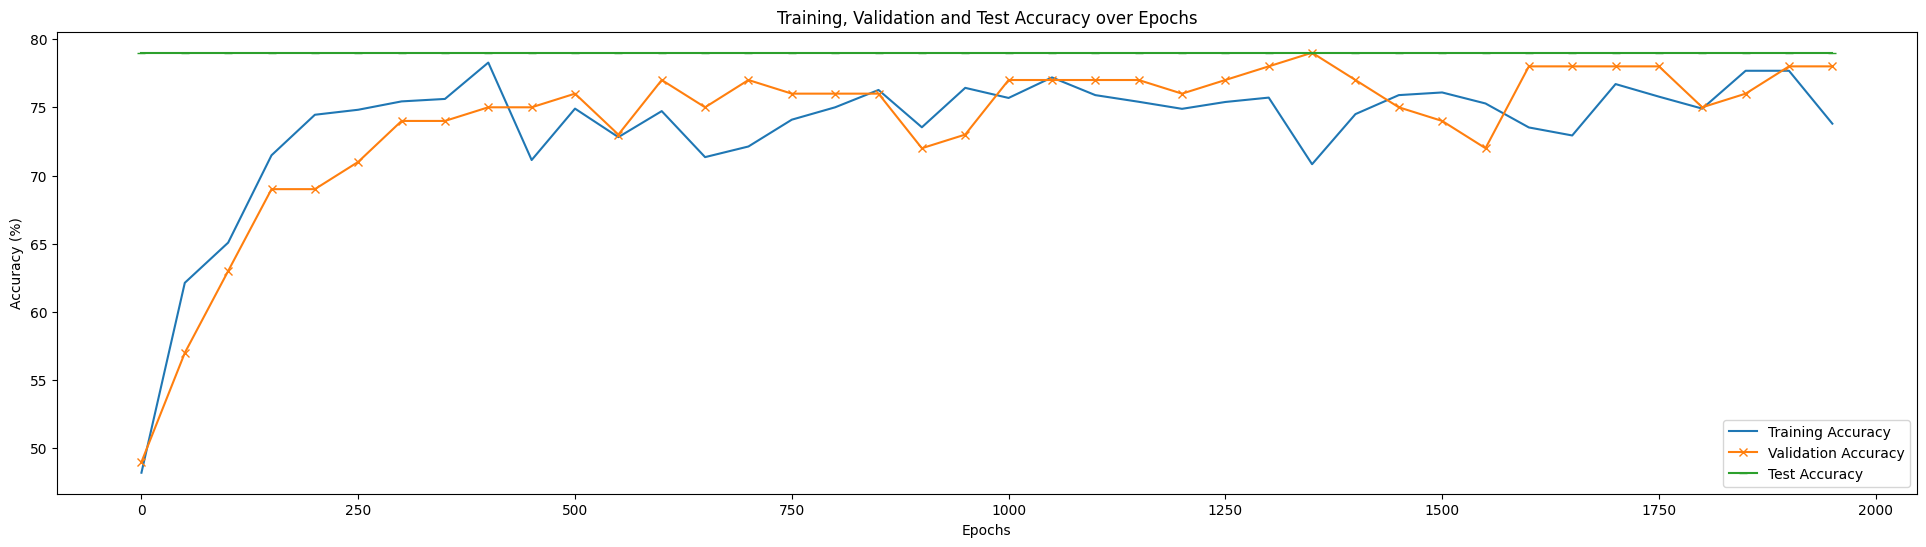

In [23]:
plt.figure(figsize=(24, 6))  # Set the figure size

# Plot training loss
plt.plot(epoch_count[::50], training_accuracy_list[::50], label='Training Accuracy')

# Plot validation loss
plt.plot(epoch_count[::50], validation_accuracy_list[::50], label='Validation Accuracy', marker='x')

plt.plot(epoch_count[::50], [test_accuracy]*len(epoch_count[::50]), label='Test Accuracy', marker='_')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training, Validation and Test Accuracy over Epochs')
plt.legend()
plt.show()

##### b. Training, Validation and Testing Loss

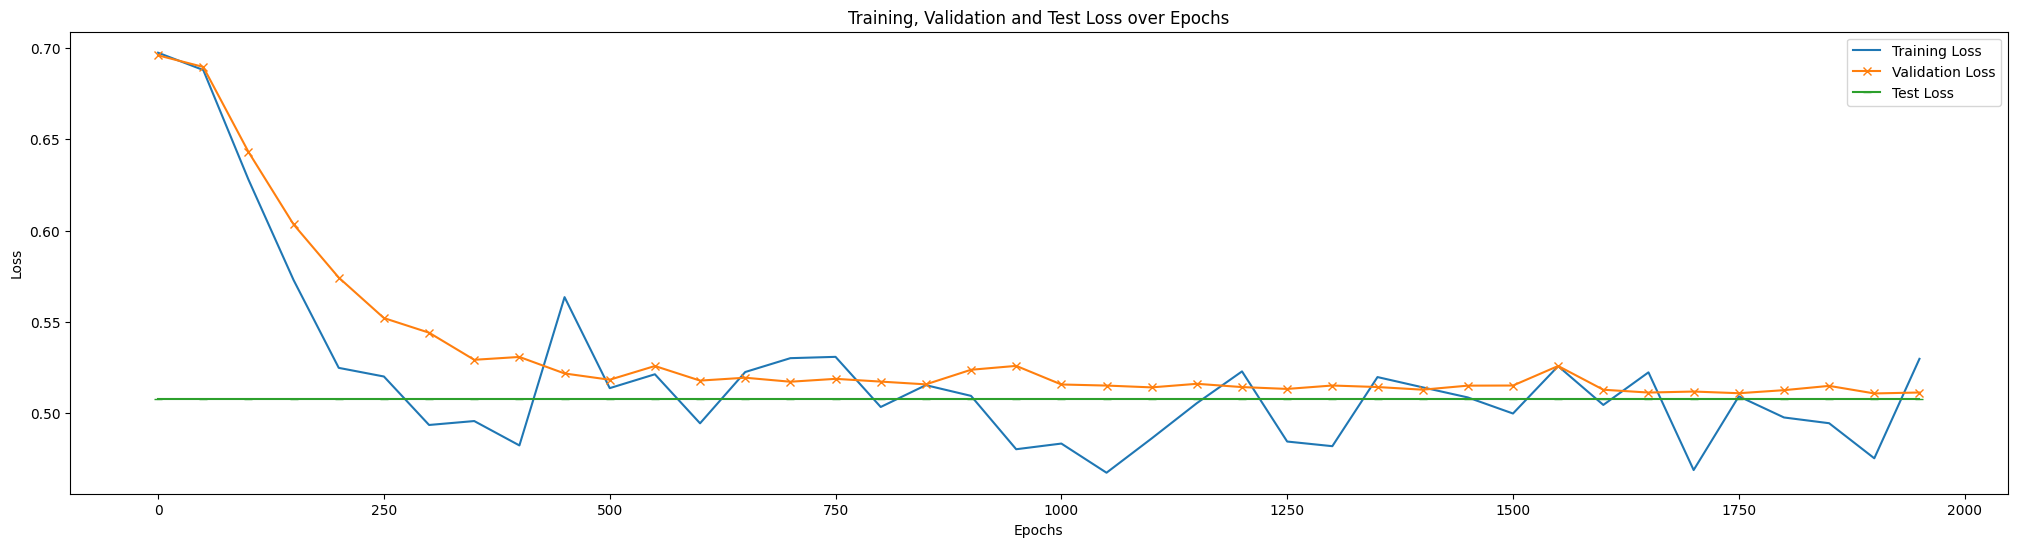

In [24]:
plt.figure(figsize=(25, 6))  # Set the figure size

# Plot training accuracy
plt.plot(epoch_count[::50], training_loss_list[::50], label='Training Loss')

# Plot validation accuracy
plt.plot(epoch_count[::50], validation_loss_list[::50], label='Validation Loss', marker='x')

plt.plot(epoch_count[::50], [test_loss]*len(epoch_count[::50]), label='Test Loss', marker='_')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss over Epochs')
plt.legend()
plt.show()

##### c. Confusion Matrix

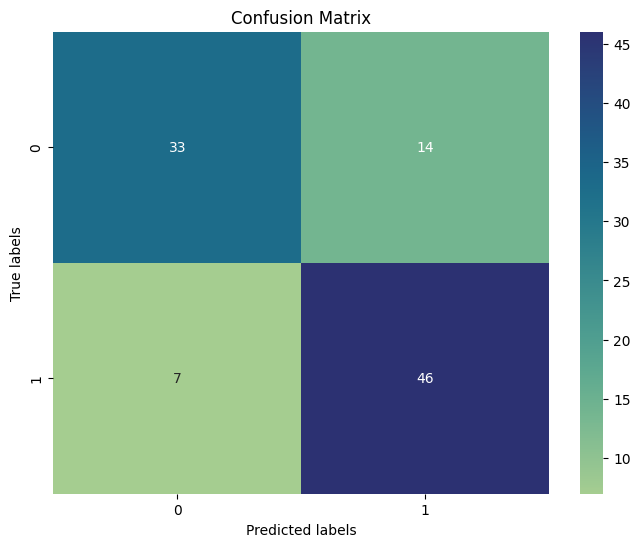

In [25]:
bcm = BinaryConfusionMatrix().to(device)
confusion_matrix = bcm(y_test_pred.squeeze(), y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix.cpu().numpy(), annot=True, cmap="crest", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

##### d. ROC curve

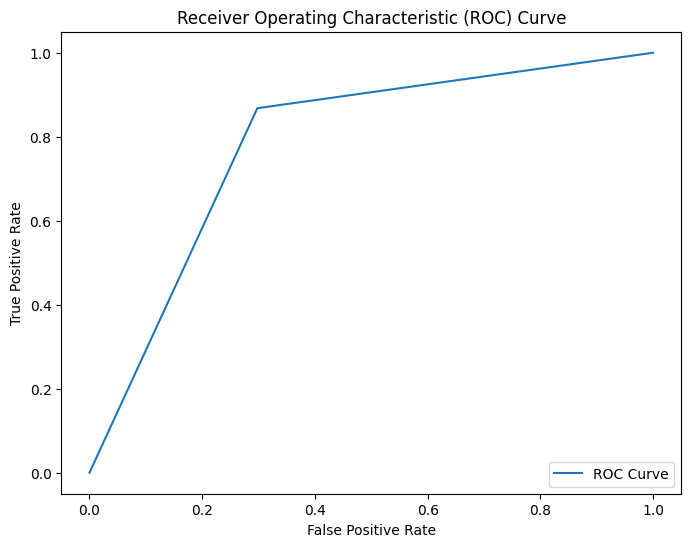

In [26]:
roc = BinaryROC()

false_positive_rate, true_positive_rate, thresholds = roc(y_test_pred.squeeze(), y_test.type(torch.int))

# Step 3: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate.cpu(), true_positive_rate.cpu(), label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()